In [128]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime as dt
import math
import plotly
import plotly.plotly as py
import plotly.graph_objs as go


In [129]:
from datetime import datetime

In [130]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
csv_path = '/Users/pbadami/Documents/njtransit/csv'

In [131]:
csv_path = '/Users/pranav/Documents/development/njtransit/csv'

In [132]:
week1 = ['2018_02_05', '2018_02_06', '2018_02_07', '2018_02_08', '2018_02_09', '2018_02_10', '2018_02_11']
week2 = ['2018_02_12', '2018_02_13', '2018_02_14', '2018_02_15', '2018_02_16', '2018_02_17', '2018_02_18']
week3 = ['2018_02_19', '2018_02_20', '2018_02_21', '2018_02_22', '2018_02_23', '2018_02_24', '2018_02_25']
week4 = ['2018_02_26', '2018_02_27', '2018_02_28', '2018_03_01', '2018_03_02', '2018_03_03', '2018_03_04']

In [133]:
all_days = week1 + week2 + week3 + week4

In [134]:
df = None
for day in all_days:
    day_df = pd.read_csv('{}/{}.csv'.format(csv_path, day))
    if df is None:
        df = day_df
    else:
        df = df.append(day_df, ignore_index=True)

In [135]:
def clean_delay(sec):
    if sec < 0:
        return 0
    else:
        return sec

# temporarily fix wrong day 
def fix_day(row):
    # wrong day
    if row['delay'] >= (1400*60):
        row['time'] = row['time'] - dt.timedelta(days=1)
        row['delay'] = (row['time'] - row['expected']).total_seconds()
    return row
        
def format_df(df):
    df['expected'] = pd.to_datetime(df['expected'])
    df['time'] = pd.to_datetime(df['time'])

    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df = df.apply(fix_day, axis=1)
    df['delay'] = df['delay'].apply(lambda x: clean_delay(x))/60.0 # clean delay and get delay in minutes
    df['status'] = df['status'].fillna("Estimated")
    return df

In [136]:
df = format_df(df)

In [137]:
trains = df.groupby(['train_id', 'date'])

In [138]:
njt_trains = df[df['type'] == 'NJ Transit']

In [139]:
njt_trains.groupby(['train_id', 'date'])

In [140]:
trains_last = trains.last()
trains_first = trains.nth(1)

In [141]:
trains_last['day_of_week'] = trains_last['time'].dt.dayofweek
trains_first['day_of_week'] = trains_first['time'].dt.dayofweek

In [142]:
trains_last['hour'] = trains_last['time'].dt.hour
trains_last['sched_hour'] = trains_last['expected'].dt.hour

trains_first['hour'] = trains_first['time'].dt.hour
trains_first['sched_hour'] = trains_first['expected'].dt.hour

In [143]:
all_trains = trains_last.copy()

In [144]:
trains_last = trains_last[trains_last['type'] == 'NJ Transit'].copy()
trains_first = trains_first[trains_first['type'] == 'NJ Transit'].copy()

In [145]:
def get_severity(row):
    delay = row['delay']
    status = row['status']
    if status == 'Cancelled':
        return "Cancelled"
    if math.isnan(delay):
        return "Unscheduled"
    if 0 <= delay < 3:
        return "On time"
    if 3 <= delay < 6:
        return "3-5 min"
    if 6 <= delay < 10:
        return "6-9 min"
    if 10 <= delay < 20:
        return "10-20 min"
    return "20+ min"

In [146]:
trains_last['severity'] = trains_last.apply(get_severity, axis=1)
trains_first['severity'] = trains_first.apply(get_severity, axis=1)

In [147]:
trains_last.reset_index(level='date', inplace=True)
trains_first.reset_index(level='date', inplace=True)

In [148]:
# turn into dict
colors={'On time': '#39e600', 
        '3-5 min': '#ffff00', 
        '6-9 min': '#ff9933', 
        '10-20 min': '#ff0000', 
        '20+ min': '#990000', 
        'Cancelled': '#827e7d'}
colors_list= ['#39e600', '#ffff00', '#ff9933', '#ff0000', '#990000', '#827e7d']

In [149]:
def plot_severity(train_subset, subset_name, ax=None, boxes=True):
    train_subset = train_subset[train_subset['severity'] != 'Unscheduled'].copy()
    severity_date = train_subset.groupby(['date','severity']).size()
    severity_pcts = severity_date.groupby(level=0).apply(lambda x: x/ float(x.sum()))*100
    severity_pcts = severity_pcts.unstack()
    severity_pcts.fillna(0, inplace=True)
    exclude_cols = ['Unscheduled']
    sum_cols = ['On time', '3-5 min', '6-9 min', '10-20 min', '20+ min', 'Cancelled']
    data = []
    for col in sum_cols:
        if col in severity_pcts.columns:
            data.append(go.Bar(x=severity_pcts.index,
                               y=severity_pcts[col],
                               name=col,
                               marker=go.Marker(color=colors[col])))
    layout = go.Layout(barmode='stack',
                       title=subset_name + " NJ Transit Performance (2/5/18 - 3/4/18)",
                       xaxis=dict(title='date'),
                       yaxis=dict(title='% of trains'))
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)
    return (train_subset.groupby('severity').size()/float(len(train_subset))).sort_values(ascending=False)*100

# System-wide severity

In [150]:
sys_wide = trains_last[trains_last['line'] != 'Princeton Shuttle'].copy()

In [151]:
len(sys_wide)

16267

In [152]:
sys_wide_pcts = plot_severity(sys_wide, "Systemwide")

In [153]:
sys_wide_pcts

severity
On time      74.881633
3-5 min      11.990408
6-9 min       5.626268
10-20 min     3.357314
20+ min       2.693230
Cancelled     1.451147
dtype: float64

In [54]:
sys_wide_pcts = sys_wide_pcts.sort_values(ascending=False)
fig = {
    'data': [{'labels': sys_wide_pcts.index,
              'values': sys_wide_pcts,
              'type': 'pie',
              'marker': {'colors': colors_list}}],
    
    'layout': {'title': 'Systemwide NJ Transit Performance (2/5/18 - 3/3/18)'}
}

plotly.offline.iplot(fig)

In [79]:
# rush hour --> weekdays, between 8-11am
sys_wide_rh = sys_wide[(sys_wide['day_of_week'] >= 0) & \
                       (sys_wide['day_of_week'] < 5) & \
                       (sys_wide['sched_hour'] > 7) & \
                       (sys_wide['sched_hour'] < 11)].copy()
sys_wide_rh = sys_wide_rh[sys_wide_rh['date'] != '2018-02-19']

In [83]:
sys_wide_rh_pcts = plot_severity(sys_wide_rh, "Systemwide A.M. Rush Hour", boxes=False)

In [81]:
sys_wide_rh_pcts

severity
On time      70.049599
3-5 min      16.596719
6-9 min       6.295307
10-20 min     3.815338
20+ min       2.594430
Cancelled     0.648607
dtype: float64

In [84]:
to_nyp_rh = sys_wide_rh[sys_wide_rh['to'] == 'New York Penn Station']

In [32]:
to_nyp_rh['date'].unique()

array(['2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
       '2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',
       '2018-02-15', '2018-02-16', '2018-02-20', '2018-02-21',
       '2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27',
       '2018-02-28', '2018-03-01', '2018-03-02'], dtype=object)

In [85]:
to_nyp_rh_pcts = plot_severity(to_nyp_rh, "To New York Penn A.M. Rush Hour", boxes=False)

In [86]:
to_nyp_rh_pcts

severity
On time      56.959064
3-5 min      20.000000
6-9 min       9.356725
10-20 min     8.070175
20+ min       4.678363
Cancelled     0.935673
dtype: float64

In [94]:
9.356725 + 8.070175 + 4.678363 + 0.935673

23.040936000000006

In [87]:
# probability of being delayed at least once 
1-(0.5696**5)

0.9400416182190631

In [88]:
# prob of experiencing > 6 min delay in a week
print (1-((0.5696 + 0.20)**5))

0.730023915047


In [89]:
# prob of experiencing > 10 min delay in 2 weeks
print (1-((0.5696 + 0.20 + 0.0936)**10))

0.770324687081


In [39]:
first_sys_wide = trains_first[trains_first['line'] != 'Princeton Shuttle'].copy()

In [40]:
len(sys_wide[sys_wide['status'] == 'Cancelled'])

216

In [41]:
len(first_sys_wide[first_sys_wide['status'] == 'Cancelled'])

158

In [98]:
first_sys_wide_pcts = plot_severity(first_sys_wide, "Systemwide Departing")

In [43]:
# rush hour --> weekdays, between 8-11am
first_sys_wide_rh = first_sys_wide[(first_sys_wide['day_of_week'] >= 0) & \
                       (first_sys_wide['day_of_week'] < 5) & \
                       (first_sys_wide['sched_hour'] > 16) & \
                       (first_sys_wide['sched_hour'] < 19)].copy()
first_sys_wide_rh = first_sys_wide_rh[first_sys_wide_rh['date'] != '2018-02-19']

In [44]:
first_sys_wide_rh

,date,delay,expected,from,from_id,line,status,stop_sequence,time,to,to_id,type,day_of_week,hour,sched_hour,severity
train_id,,,,,,,,,,,,,,,,
0055,2018-02-05,1.316667,2018-02-05 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-05 17:26:19,Secaucus Lower Lvl,38174.0,NJ Transit,0,17,17.0,On time
0055,2018-02-06,2.300000,2018-02-06 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-06 17:27:18,Secaucus Lower Lvl,38174.0,NJ Transit,1,17,17.0,On time
0055,2018-02-07,2.350000,2018-02-07 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-07 17:27:21,Secaucus Lower Lvl,38174.0,NJ Transit,2,17,17.0,On time
0055,2018-02-08,2.283333,2018-02-08 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-08 17:27:17,Secaucus Lower Lvl,38174.0,NJ Transit,3,17,17.0,On time
0055,2018-02-09,3.283333,2018-02-09 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-09 17:28:17,Secaucus Lower Lvl,38174.0,NJ Transit,4,17,17.0,3-5 min
0055,2018-02-12,1.233333,2018-02-12 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-12 17:26:14,Secaucus Lower Lvl,38174.0,NJ Transit,0,17,17.0,On time
0055,2018-02-13,2.216667,2018-02-13 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-13 17:27:13,Secaucus Lower Lvl,38174.0,NJ Transit,1,17,17.0,On time
0055,2018-02-14,0.366667,2018-02-14 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-14 17:25:22,Secaucus Lower Lvl,38174.0,NJ Transit,2,17,17.0,On time
0055,2018-02-15,2.200000,2018-02-15 17:25:00,Hoboken,63.0,Bergen Co. Line,Departed,2.0,2018-02-15 17:27:12,Secaucus Lower Lvl,38174.0,NJ Transit,3,17,17.0,On time


In [45]:
first_sys_wide_rh_pcts = plot_severity(first_sys_wide_rh, "Systemwide Evening Rush Hour")

In [90]:
first_sys_wide_rh_nyp = first_sys_wide_rh[first_sys_wide_rh['from'] == 'New York Penn Station'].copy()

In [97]:
len(first_sys_wide_rh_nyp[(first_sys_wide_rh_nyp['date'] == '2018-03-02') & (first_sys_wide_rh_nyp['status'] == 'Cancelled')])

18

In [91]:
first_sys_wide_rh_nyp_pcts = plot_severity(first_sys_wide_rh_nyp, "From NY Penn Evening Rush Hour")

In [92]:
first_sys_wide_rh_nyp_pcts

severity
On time      46.034483
3-5 min      39.137931
6-9 min       6.206897
Cancelled     4.137931
10-20 min     2.586207
20+ min       1.896552
dtype: float64

In [93]:
6.206897 + 4.137931 + 2.586207 + 1.896552

14.827587

In [48]:
len(to_nyp_rh)

855

In [49]:
len(first_sys_wide_rh_nyp)

580

In [51]:
first_sys_wide_rh_nyp_pcts = first_sys_wide_rh_nyp_pcts.sort_values(ascending=False)
fig = {
    'data': [{'labels': first_sys_wide_rh_nyp_pcts.index,
              'values': first_sys_wide_rh_nyp_pcts,
              'type': 'pie',
              'marker': {'colors': colors_list}}],
    
    'layout': {'title': 'Out of New York Penn PM Rush Hour Performance (2/5/18 - 3/2/18)'}
}

plotly.offline.iplot(fig)

# NEC severity

In [52]:
nec = trains_last[trains_last['line'] == 'Northeast Corrdr'].copy()

In [53]:
plot_severity(nec, "Northeast Corridor")

severity
10-20 min    0.041223
20+ min      0.039894
3-5 min      0.086436
6-9 min      0.054854
Cancelled    0.016955
On time      0.760638
dtype: float64

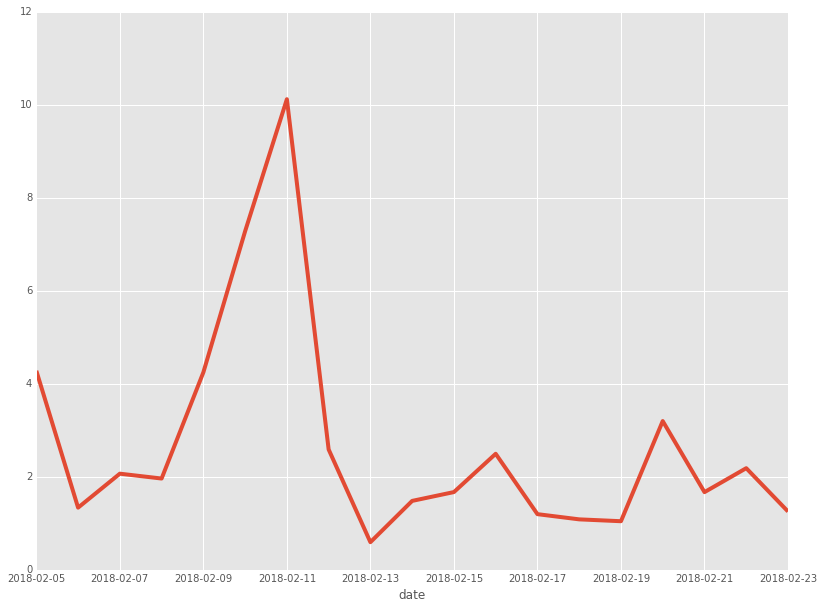

In [487]:
nec.groupby('date')['delay'].mean().plot(figsize=(12,10))

# NJCL Severity

In [62]:
njcl = trains_last[trains_last['line'] == 'No Jersey Coast'].copy()

In [64]:
plot_severity(njcl, "No Jersey Coast Line")

severity
10-20 min    0.038064
20+ min      0.007613
3-5 min      0.101142
6-9 min      0.056552
Cancelled    0.009244
On time      0.787384
dtype: float64

# MB Severity

In [65]:
mobo = trains_last[trains_last['line'] == 'Montclair-Boonton'].copy()

In [66]:
plot_severity(mobo, "Montclair-Boonton Line")

severity
10-20 min    0.031809
20+ min      0.007952
3-5 min      0.156064
6-9 min      0.083499
Cancelled    0.013917
On time      0.706759
dtype: float64

# Gladstone Severity

In [1]:
gladstone = trains_last[trains_last['line'] == 'Gladstone Branch'].copy()

NameError: name 'trains_last' is not defined

In [ ]:
plot_severity(gladstone, 'Gladstone Branch')

# Pascack Severity

In [67]:
pascack = trains_last[trains_last['line'] == 'Pascack Valley'].copy()

In [68]:
plot_severity(pascack, 'Pascack Valley')

severity
10-20 min    0.016949
20+ min      0.004622
3-5 min      0.115562
6-9 min      0.024653
Cancelled    0.001541
On time      0.836672
dtype: float64

# Raritan Severity

In [69]:
raritan = trains_last[trains_last['line'] == 'Raritan Valley'].copy()

In [70]:
plot_severity(raritan, 'Raritan Valley')

severity
10-20 min    0.012304
20+ min      0.006711
3-5 min      0.073826
6-9 min      0.032438
Cancelled    0.005593
On time      0.869128
dtype: float64

# Bergen Line

In [71]:
bergen = trains_last[trains_last['line'] == 'Bergen Co. Line '].copy()

In [72]:
plot_severity(bergen, 'Bergen Co. Line ')

severity
10-20 min    0.035934
20+ min      0.012320
3-5 min      0.154004
6-9 min      0.042094
Cancelled    0.007187
On time      0.748460
dtype: float64

# Main Line

In [73]:
main = trains_last[trains_last['line'] == 'Main Line'].copy()

In [74]:
plot_severity(main, 'Main Line')

severity
10-20 min    0.024494
20+ min      0.014909
3-5 min      0.170394
6-9 min      0.064963
Cancelled    0.005325
On time      0.719915
dtype: float64

# Atlantic City Line

In [75]:
ac = trains_last[trains_last['line'] == 'Atl. City Line'].copy()

In [76]:
plot_severity(ac, 'Atl. City Line')

severity
10-20 min    0.128505
20+ min      0.091121
3-5 min      0.200935
6-9 min      0.126168
Cancelled    0.014019
On time      0.439252
dtype: float64

In [400]:
type(ac[ac['date']=='2018-02-08'].iloc[-1][-2])

numpy.float64

# Morristown Line

In [77]:
morris = trains_last[trains_last['line'] == 'Morristown Line'].copy()

In [78]:
plot_severity(morris, 'Morristown Line')

severity
10-20 min    0.027864
20+ min      0.017337
3-5 min      0.129412
6-9 min      0.060062
Cancelled    0.014241
On time      0.751084
dtype: float64

# Dinky Line

In [59]:
dinky = trains_last[trains_last['line'] == 'Princeton Shuttle'].copy()

In [60]:
dinky.groupby('severity').size()

severity
6-9 min       5
On time    1389
dtype: int64

In [61]:
plot_severity(dinky, 'Princeton Shuttle')

severity
6-9 min    0.003587
On time    0.996413
dtype: float64

# All Trains Volume

In [505]:
all_nec = all_trains[(all_trains['line'].isin(['Northeast Corrdr','No Jersey Coast'])) | (all_trains['type'] == "Amtrak")].copy()

In [507]:
def get_line_proxy(row):
    if row['type'] == 'Amtrak':
        row['proxy_line'] = 'Amtrak'
    elif row['line'] == 'Northeast Corrdr':
        row['proxy_line'] = 'Northeast Corrdr'
    else:
        row['proxy_line'] = 'No Jersey Coast'
    return row

In [508]:
all_nec = all_nec.apply(get_line_proxy, axis=1)

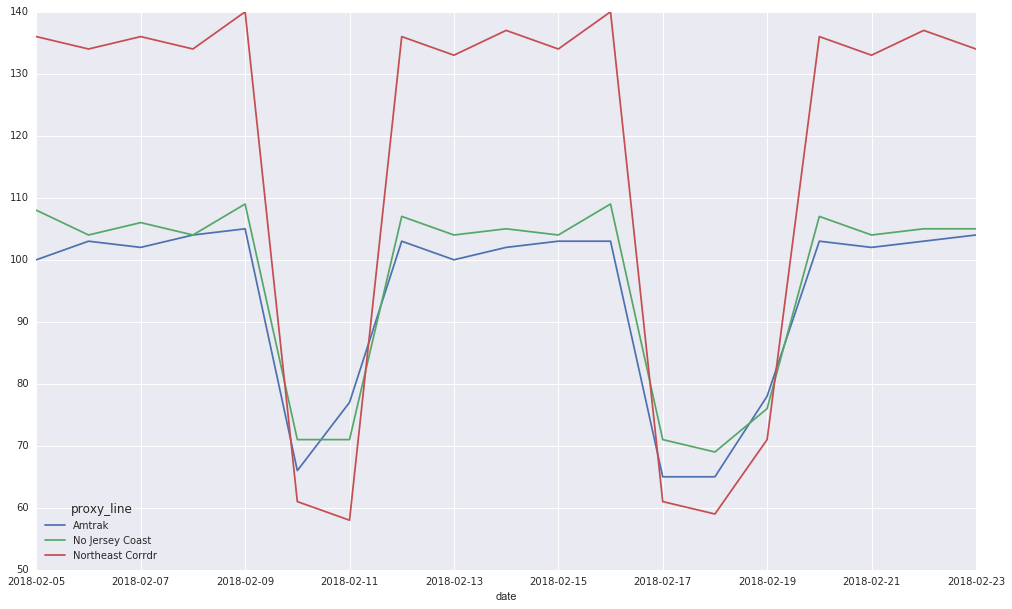

In [796]:
all_nec.groupby(['date', 'proxy_line']).size().unstack().plot(figsize=(15,10))

In [797]:
all_nec.groupby('proxy_line').size()/len(all_nec)

proxy_line
Amtrak              0.306322
No Jersey Coast     0.315059
Northeast Corrdr    0.378619
dtype: float64

In [30]:
to_nyp_220_am = sys_wide[(sys_wide['day_of_week'] >= 1) & \
                       (sys_wide['day_of_week'] <= 5) & \
                       (sys_wide['sched_hour'] >= 6) & \
                       (sys_wide['sched_hour'] <= 10) & \
                       (sys_wide['to'] == 'New York Penn Station') &\
                       (sys_wide['date'] == '2018-02-20')].copy()

In [31]:
to_nyp_rh_220 = to_nyp_rh[to_nyp_rh['date'] == '2018-02-20'].copy()

In [32]:
to_nyp_rh_220['expected_fmt'] = to_nyp_rh_220['expected'].dt.strftime('%H:%M')
to_nyp_220_am['expected_fmt'] = to_nyp_220_am['expected'].dt.strftime('%H:%M')

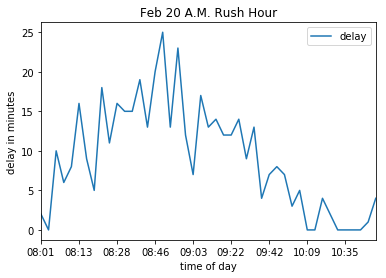

In [33]:
ax = to_nyp_rh_220.sort_values('expected').plot(x='expected_fmt', y='delay', title='Feb 20 A.M. Rush Hour')
ax.set_ylabel('delay in minutes')
ax.set_xlabel('time of day')

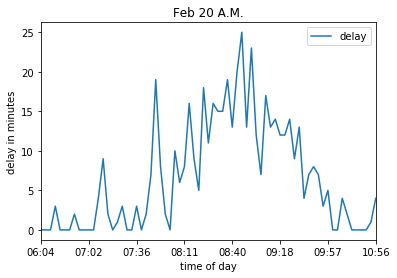

In [34]:
ax = to_nyp_220_am.sort_values('expected').plot(x='expected_fmt', y='delay', title='Feb 20 A.M.')
ax.set_ylabel('delay in minutes')
ax.set_xlabel('time of day')

In [35]:
to_nyp_220_am[to_nyp_220_am['delay'] > 2]['delay'].mean()

9.8541666666666661